In [1]:
from sklearn.model_selection import train_test_split
import pandas
import numpy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pprint import pprint
from imblearn.under_sampling import ClusterCentroids
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
pandas.set_option('display.float_format', lambda x: '%.5f' % x)

**Reading Data**

In [2]:
data = pandas.read_csv('cs-training.csv')

# EDA, Data Preparation and Feature Extraction

In [3]:
data.isna().sum()/len(data)

Unnamed: 0                             0.00000
SeriousDlqin2yrs                       0.00000
RevolvingUtilizationOfUnsecuredLines   0.00000
age                                    0.00000
NumberOfTime30-59DaysPastDueNotWorse   0.00000
DebtRatio                              0.00000
MonthlyIncome                          0.19821
NumberOfOpenCreditLinesAndLoans        0.00000
NumberOfTimes90DaysLate                0.00000
NumberRealEstateLoansOrLines           0.00000
NumberOfTime60-89DaysPastDueNotWorse   0.00000
NumberOfDependents                     0.02616
dtype: float64

**Removing NaNs and cleaning data**

In [4]:
data.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
data.dropna(axis=0,how='any',subset=['MonthlyIncome'],inplace=True)
data.reset_index()

train_frame = data[data.columns[1:]]

**Creating new features and cleaning more**

In [5]:
train_frame['MonthlyDebt'] = train_frame['DebtRatio']*train_frame['MonthlyIncome']
train_frame['NumOfPastDue'] = train_frame['NumberOfTimes90DaysLate']+train_frame['NumberOfTime60-89DaysPastDueNotWorse'] +train_frame['NumberOfTime30-59DaysPastDueNotWorse']
train_frame['MonthlyBalance'] = train_frame['MonthlyIncome']-train_frame['MonthlyDebt']
train_frame['NumOfOpenCreditLines'] = train_frame['NumberOfOpenCreditLinesAndLoans']-train_frame['NumberRealEstateLoansOrLines']
train_frame['IncomePerPerson'] = train_frame['MonthlyIncome']/(train_frame['NumberOfDependents']+1)

# We need only the observations where MonthlyBalance is positive
train_frame['MonthlyBalance'][train_frame['MonthlyBalance'] <= 0] = 1

C:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Detecting and Removing outliers**

In [6]:
train_frame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,120269.00000,0.06949,0.25428,0.00000,0.00000,0.00000,0.00000,1.00000
RevolvingUtilizationOfUnsecuredLines,120269.00000,5.89987,257.04068,0.00000,0.03508,0.17728,0.57943,50708.00000
age,120269.00000,51.28979,14.42668,0.00000,40.00000,51.00000,61.00000,103.00000
NumberOfTime30-59DaysPastDueNotWorse,120269.00000,0.38177,3.49923,0.00000,0.00000,0.00000,0.00000,98.00000
DebtRatio,120269.00000,26.59878,424.44646,0.00000,0.14339,0.29602,0.48256,61106.50000
MonthlyIncome,120269.00000,6670.22124,14384.67422,0.00000,3400.00000,5400.00000,8249.00000,3008750.00000
NumberOfOpenCreditLinesAndLoans,120269.00000,8.75847,5.17284,0.00000,5.00000,8.00000,11.00000,58.00000
NumberOfTimes90DaysLate,120269.00000,0.21192,3.46528,0.00000,0.00000,0.00000,0.00000,98.00000
NumberRealEstateLoansOrLines,120269.00000,1.05452,1.14927,0.00000,0.00000,1.00000,2.00000,54.00000
NumberOfTime60-89DaysPastDueNotWorse,120269.00000,0.18783,3.44790,0.00000,0.00000,0.00000,0.00000,98.00000


In [7]:
print('Percentage of outliers in age: {}'.format(train_frame.query('age == 0 or age >= 99').size/len(train_frame)))
print('Percentage of outliers in RevolvingUtilizationOfUnsecuredLines: {}'.format(train_frame.query('RevolvingUtilizationOfUnsecuredLines > 5').size/len(train_frame)))
print('Percentage of outliers in DebtRatio: {}'.format(train_frame.query('DebtRatio > 9000').size/len(train_frame)))

Percentage of outliers in age: 0.001330351129551256
Percentage of outliers in RevolvingUtilizationOfUnsecuredLines: 0.024212390557832857
Percentage of outliers in DebtRatio: 0.0029267724850127633


In [8]:
train_frame = train_frame.query('age > 0 and age < 99').query('RevolvingUtilizationOfUnsecuredLines < 5').query('DebtRatio < 9000')

**Plot the distribution of each variable to see how skewed they are**

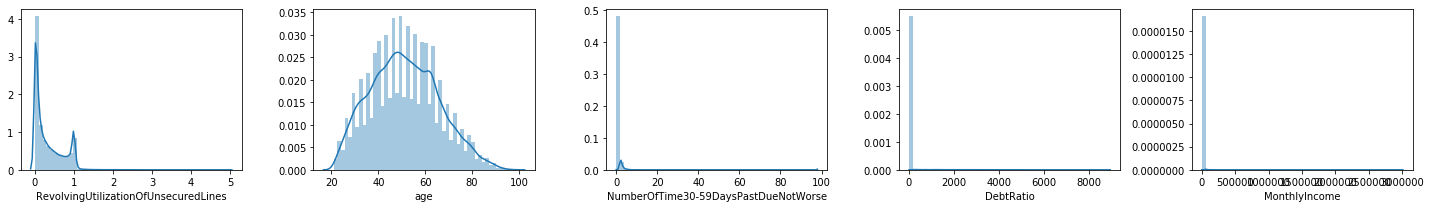

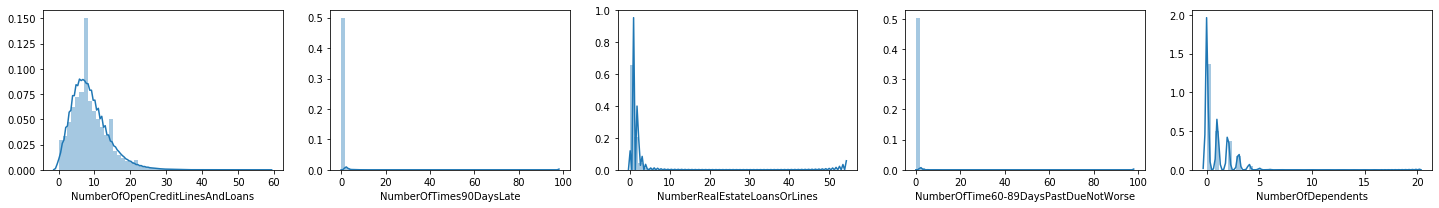

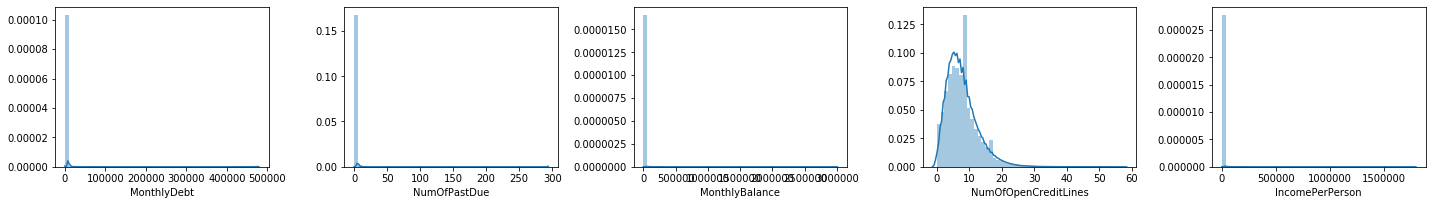

In [9]:
# Uncomment below lines if needed
columns = train_frame.columns[1:]
for cols in numpy.split(columns, 3):
    fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
    for each in range(len(cols)):
        sns.distplot(train_frame[cols[each]], ax=axes[each])
    plt.tight_layout()

**Taking log transform to reduce skeweness in some variables**

In [10]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 
               'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt','MonthlyIncome', 'DebtRatio',
               'NumberRealEstateLoansOrLines', 'IncomePerPerson', 'MonthlyBalance']:
    train_frame[column] = numpy.log10(1 + train_frame[column].values)

**Plot distribution again**

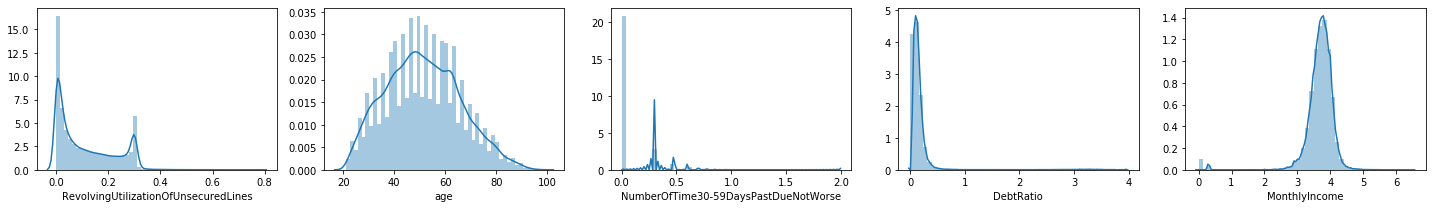

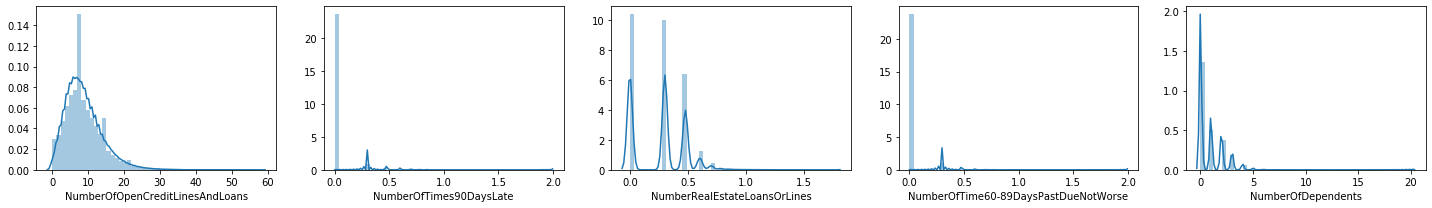

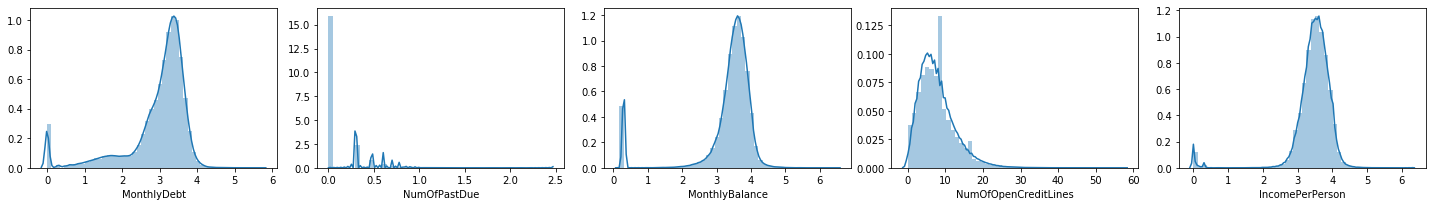

In [11]:
# Uncomment below lines if needed

columns = train_frame.columns[1:]
for cols in numpy.split(columns, 3):
    fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
    for each in range(len(cols)):
        sns.distplot(train_frame[cols[each]], ax=axes[each])
    plt.tight_layout()

**Util Methods**

In [12]:
def split_dataset(features):
    x = train_frame[features]
    y = train_frame['SeriousDlqin2yrs']
    return train_test_split(x, y, test_size=0.2, random_state=0)

In [13]:
def scalar_transform(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    return scaler.transform(x_train), scaler.transform(x_test)

In [14]:
def tune_hyper_parameters(x_train, y_train):
    rf = RandomForestClassifier(oob_score=True, \
                                min_samples_split=2, \
                                min_samples_leaf=50, \
                                n_jobs=-1, \
                                #class_weight="balanced",\
                                class_weight="balanced_subsample", \
                                bootstrap=True\
                                )
    param_grid = {"n_estimators": [90, 100, 110, 130], "max_features": [2, 3, 4], "min_samples_leaf":[50]}
    grid_search = GridSearchCV(rf, cv=10, scoring='roc_auc', param_grid=param_grid, iid=False)
    grid_search.fit(x_train, y_train)
    pprint(grid_search.best_params_)
    pprint(grid_search.best_score_)

In [15]:
def train(x_train, y_train):
    rf = RandomForestClassifier(n_estimators=130, \
                                oob_score=True, \
                                min_samples_split=2, \
                                min_samples_leaf=50, \
                                n_jobs=-1, \
                                #class_weight="balanced",\
                                class_weight="balanced_subsample", \
                                bootstrap=True, \
                                max_features=3, \
                                criterion='entropy'
                                )
    return rf.fit(x_train, y_train)

In [16]:
def plot(y_test, y_pred):
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf_matrix, annot = True, fmt = "d", square=True, cmap = plt.cm.Greens)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.tight_layout()

In [17]:
def oversample(x_train, y_train):
    X = pandas.concat([x_train, y_train], axis=1)
    no_risk = X[X.SeriousDlqin2yrs==0]
    risk = X[X.SeriousDlqin2yrs==1]
    risk_oversampled = resample(risk,replace=True, # sample with replacement
                              n_samples=len(no_risk), # match number in majority class
                              random_state=27) # reproducible results
    upsampled = pandas.concat([no_risk, risk_oversampled])
    return upsampled.iloc[:, :-1], upsampled.SeriousDlqin2yrs

In [18]:
def smote_over(x_train, y_train):
    smote = SMOTE(ratio='minority')
    return smote.fit_sample(x_train, y_train)

In [19]:
def cc_under(x_train, y_train):
    cc = ClusterCentroids(random_state=42)
    return cc.fit_resample(x_train, y_train)

In [20]:
from imblearn.combine import SMOTETomek

def combine(x_train, y_train):
    smt = SMOTETomek(ratio='auto')
    return smt.fit_sample(x_train, y_train)

In [21]:
def evaluate(y_test, y_pred):
    return_str = ''
    accuracy = metrics.accuracy_score(y_test, y_pred)
    return_str += 'Accuracy: {}'.format( accuracy ) + '\n'
    return_str += 'Error: {}'.format( 1 - accuracy ) + '\n'
    return_str += 'Precision: {}'.format( metrics.precision_score(y_test, y_pred, average = None) ) + '\n'
    return_str += 'Recall: {}'.format( metrics.recall_score(y_test, y_pred, average = None) ) + '\n'
    return_str += 'F1 Score: {}'.format( metrics.f1_score(y_test, y_pred, average = None) )
    return return_str

# Hyper-parameter Tuning and Feature Selection

We have used all the variables and plotted their relative importance.

In [22]:
features = train_frame.columns[1:]
x_train, x_test, y_train, y_test = split_dataset(features)
# x_train, y_train = cc_under(x_train, y_train)
x_train, x_test = scalar_transform(x_train, x_test)

In [23]:
tune_hyper_parameters(x_train, y_train)

{'max_features': 3, 'min_samples_leaf': 50, 'n_estimators': 130}
0.8523999703840074


In [24]:
rf = train(x_train, y_train)

In [25]:
y_pred = rf.predict(x_test)

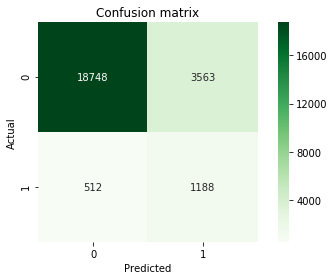

In [26]:
plot(y_test, y_pred)

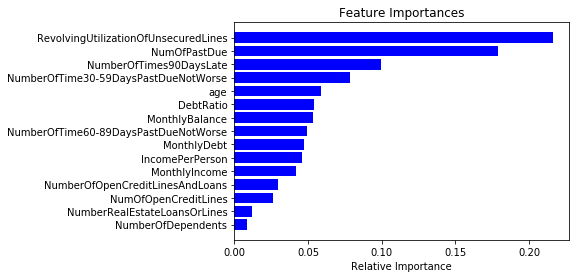

In [27]:
importances = rf.feature_importances_
indices = numpy.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Model Training and Evaluation

In [28]:
features = ['RevolvingUtilizationOfUnsecuredLines','MonthlyDebt', 'MonthlyIncome', 'DebtRatio','age', 
            'IncomePerPerson', 'MonthlyBalance', 'NumOfOpenCreditLines','NumberOfTime30-59DaysPastDueNotWorse', 
            'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue']
x_train, x_test, y_train, y_test = split_dataset(features)
# x_train, y_train = cc_under(x_train, y_train)
x_train, x_test = scalar_transform(x_train, x_test)
rf = train(x_train, y_train)

In [29]:
y_pred = rf.predict(x_test)

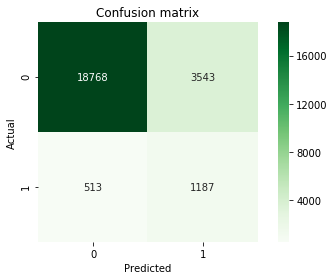

In [30]:
plot(y_test, y_pred)

In [31]:
print(evaluate(y_test, y_pred))

Accuracy: 0.8310774228478613
Error: 0.16892257715213865
Precision: [0.9733935  0.25095137]
Recall: [0.84119941 0.69823529]
F1 Score: [0.90248125 0.36920684]


# Predicting Test data

In [32]:
test_data = pandas.read_csv('cs-test.csv')

In [33]:
test_data = test_data[data.columns[2:]]

In [34]:
test_data['MonthlyDebt'] = test_data['DebtRatio']*test_data['MonthlyIncome']
test_data['NumOfPastDue'] = test_data['NumberOfTimes90DaysLate']+test_data['NumberOfTime60-89DaysPastDueNotWorse'] +test_data['NumberOfTime30-59DaysPastDueNotWorse']
test_data['NumOfOpenCreditLines'] = test_data['NumberOfOpenCreditLinesAndLoans']-test_data['NumberRealEstateLoansOrLines']
test_data['IncomePerPerson'] = test_data['MonthlyIncome']/(test_data['NumberOfDependents']+1)
test_data['MonthlyBalance'] = test_data['MonthlyIncome']-test_data['MonthlyDebt']

test_data['MonthlyBalance'][test_data['MonthlyBalance'] <= 0] = 1

C:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [35]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines', 'IncomePerPerson', 'MonthlyBalance']:
    test_data[column] = numpy.log10(1 + test_data[column].values)

In [36]:
x = test_data[features]

In [37]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [38]:
imp = SimpleImputer()
imp = imp.fit(x)
x = imp.transform(x)

In [39]:
probs = rf.predict_proba(x)
dlq = rf.predict(x)

In [40]:
probs = [each[1] for each in probs]

In [41]:
out = pandas.DataFrame()
out['Probability'] = probs
out['SeriousDlqin2yrs'] = dlq
out.index = out.index+1

In [42]:
out.to_csv('out.csv')